In [1]:
import numpy as np
from tqdm import tqdm_notebook

from tools.data_loading import load_images, load_labels, dummy_code, load_images_resized
from tools.feature_learning import pins_generation
from tools.hog import hog
from tools.kernels import kernel_matrix
from tools.optimization import find_f
from tools.prediction import pred
from tools.process_images import process_images
from tools.quantization import kmeans
from tools.submission import labels_to_csv
from tools.visualization import imshow, dump_as_png, reshape_as_images

# Data loading

In [2]:
X_train = load_images(type="train")
n_train = X_train.shape[0]
Y_labels_train = load_labels()
Y_train = dummy_code(Y_labels_train)
n_classes = Y_train.shape[1]

In [3]:
image_list = reshape_as_images(X_train)

# Visual features

In [4]:
filter_sigma=0.1
filter_shape=5
hog_cell_size=8
disc_grid=16

In [5]:
n_images = image_list.shape[0]

In [6]:
hog_list = []
for i in tqdm_notebook(range(n_images), desc="Images"):
    image = image_list[i,:,:,:]
    hog_list.append(
        hog(
            image,
            filter_sigma=filter_sigma,
            filter_shape=filter_shape,
            hog_cell_size=hog_cell_size,
            disc_grid=disc_grid))
    
n_features = hog_list[0].size
X_hog = np.array(hog_list).reshape((n_images, n_features)) 


# Data separation

In [7]:
indices = np.random.permutation(X_hog.shape[0])
training_idx, test_idx = indices[:int(0.8*n_train)], indices[int(0.8*n_train):]

X_sample = X_hog[training_idx, :]
n_sample = X_sample.shape[0]
Y_sample = Y_train[training_idx,:]
Y_labels_sample = Y_labels_train[training_idx]

X_test = X_hog[test_idx, :]
n_test = X_test.shape[0]
Y_labels_test = Y_labels_train[test_idx]

# Training

In [8]:
kernel_type = "polynomial"
classifier_type = "svm"
degree = 4
constant = 5
lamb = 0.01
n_iter = 50000

## Kernel choice

In [9]:
K_sample = kernel_matrix(X_sample, kernel_type=kernel_type, degree=degree, constant=constant)

In [10]:
K_sample.shape

(4000, 4000)

## Classifier choice

In [ ]:
alpha = np.zeros((n_classes, n_sample))
obj_func = np.zeros((n_classes, n_iter))
for dig in tqdm_notebook(range(n_classes), desc="Classes"):
    alpha[dig, :], obj_func[dig, :] = find_f(K_sample, Y_sample[:, dig],
                           prob_type=classifier_type, lamb=lamb, n_iter=n_iter)

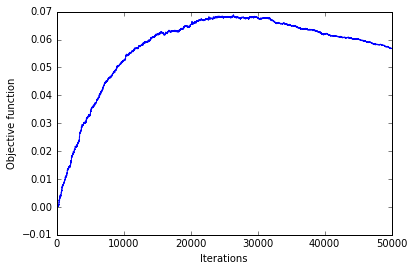

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.ylabel("Objective function")
plt.xlabel("Iterations")
plt.plot(obj_func[0, :])

## Evaluation

### Training error

In [32]:
Y_pred_train = np.zeros((X_sample[:500].shape[0], n_classes))
for dig in tqdm_notebook(range(n_classes), desc="Classes"):
    Y_pred_train[:, dig] = pred(X_sample, X_sample[:500], alpha[dig, :],
                          kernel_type=kernel_type, degree=degree, constant=constant)


Y_labels_pred_train = np.argmax(Y_pred_train, axis=1)
prec = np.mean(Y_labels_pred_train == Y_labels_sample[:500])
print("The precision on the train set is of {}".format(prec))


The precision on the train set is of 1.0


### Testing error

In [33]:
Y_pred = np.zeros((X_test.shape[0], n_classes))
for dig in tqdm_notebook(range(n_classes), desc="Classes"):
    Y_pred[:, dig] = pred(X_sample, X_test, alpha[dig, :],
                          kernel_type=kernel_type, degree=degree, constant=constant)


Y_labels_pred = np.argmax(Y_pred, axis=1)
prec = np.mean(Y_labels_pred == Y_labels_test)
print("The precision on the test set is of {}".format(prec))


The precision on the test set is of 0.553


In [35]:
1 / (2 * lamb * n_sample)

0.0125